# Tratamento de Dados
Faça a leitura dos bancos de dados. Em seguida, faça o tratamento que julgar necessário para as variáveis (exemplo: tratamento das categorias 7 = “Se recusou a responder” e 9 = “Não sabe”).

Depois, combine os dois bancos de dados fornecidos, utilizando a variável `SEQN` como chave única. O banco de dados final deve conter 5334 observações dos adultos respondentes do NHANES.

Em seguida, crie a variável `phq9` - escore Patient Health Questionnaire-9 como a soma das variáveis `DPQ010` a `DPQ090`

Por fim, crie a variável `phq_grp` - grupo de sintomas de depressão que assume:
- 0 (“sem sintomas”) se phq9 < 5
- 1 (“sintomas leves”) se 5 <= phq9 < 10
- 2 (“sintomas moderados”) se 10 <= phq9 < 15
- 3 (“sintomas moderadamente severos”) se 15 <= phq9 < 19
- 4 (“sintomas severos”) se phq9 >= 20

## Inicialização

### Importando pacotes e carregando dados

In [1]:
import numpy as np
import missingno as msno
import pandas as pd
import seaborn as sns
import utils

# Oculta warnings do notebook
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
dataset_path = '../data/raw/'

# PHQ e Demográficos
demo_phq_dataset_name = 'DEMO_PHQ.csv'
demo_phq = pd.read_csv(f"{dataset_path}{demo_phq_dataset_name}", sep=',')

# PAG e HEI
pag_hei_dataset_name = 'PAG_HEI.csv'
pag_hei = pd.read_csv(f"{dataset_path}{pag_hei_dataset_name}", sep=',')

## DEMO_PHQ

### Checando dataset

In [3]:
demo_phq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      5334 non-null   int64  
 1   DPQ010    4836 non-null   float64
 2   DPQ020    4836 non-null   float64
 3   DPQ030    4836 non-null   float64
 4   DPQ040    4836 non-null   float64
 5   DPQ050    4836 non-null   float64
 6   DPQ060    4836 non-null   float64
 7   DPQ070    4836 non-null   float64
 8   DPQ080    4836 non-null   float64
 9   DPQ090    4836 non-null   float64
 10  RIAGENDR  5334 non-null   int64  
 11  RIDAGEYR  5334 non-null   int64  
 12  RIDRETH1  5334 non-null   int64  
 13  DMDEDUC   5334 non-null   int64  
 14  INDFMINC  5287 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 625.2 KB


In [4]:
demo_phq.describe()

,SEQN,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,RIAGENDR,RIDAGEYR,RIDRETH1,DMDEDUC,INDFMINC
count,"5,334.00","4,836.00","4,836.00","4,836.00","4,836.00","4,836.00","4,836.00","4,836.00","4,836.00","4,836.00","5,334.00","5,334.00","5,334.00","5,334.00","5,287.00"
mean,"36,358.80",0.31,0.31,0.55,0.72,0.32,0.21,0.23,0.15,0.05,1.52,45.09,2.87,3.23,8.74
std,"2,964.73",0.76,0.71,0.93,0.91,0.74,0.62,0.64,0.59,0.33,0.50,20.15,1.13,1.27,12.78
min,"31,130.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,18.00,1.00,1.00,1.00
25%,"33,838.50",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,27.00,3.00,2.00,4.00
50%,"36,347.50",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,43.00,3.00,3.00,7.00
75%,"38,915.75",0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,2.00,62.00,4.00,4.00,10.00
max,"41,473.00",9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,2.00,85.00,5.00,9.00,99.00


In [5]:
# Separando as colunas de respostas PHQ-9
is_phq_column = lambda x: True if (x.find('DPQ') > -1) else False
phq_cols = [col for col in demo_phq.columns if is_phq_column(col)]

# Separando as colunas de respostas demograficas
demo_cols = ['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC', 'INDFMINC']

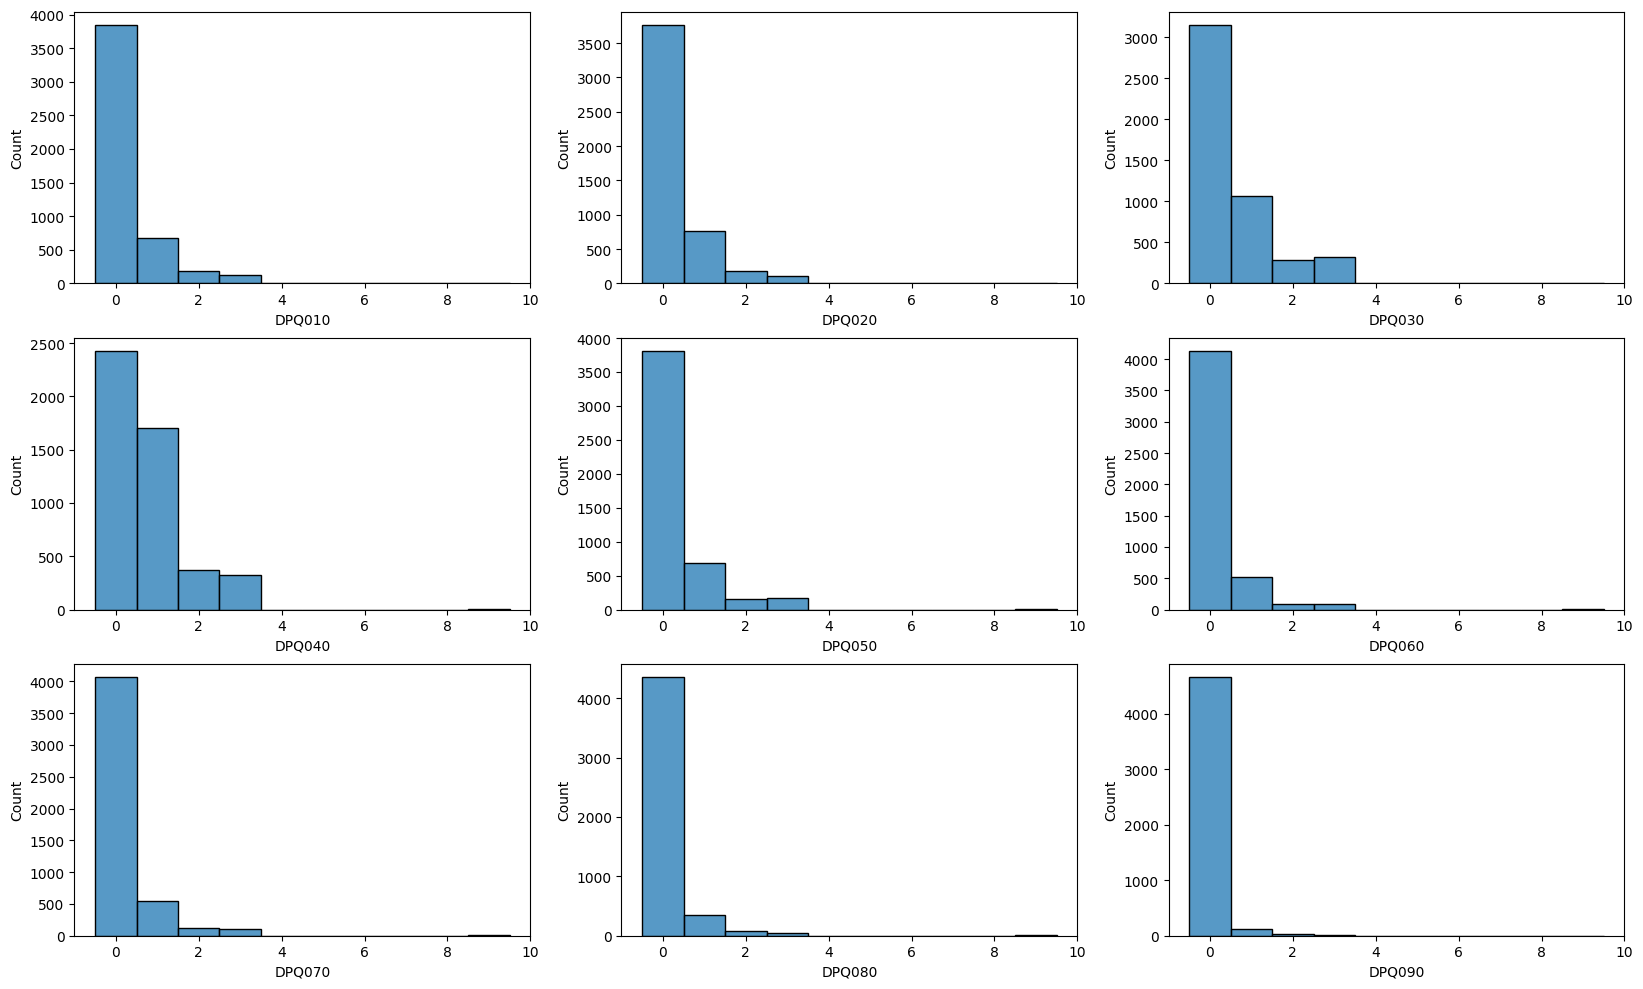

In [6]:
# Visualizando os dados de forma geral
func = sns.histplot
kwargs = {"discrete": True, }

utils.plot_for_cols(demo_phq, phq_cols, func=func, kwargs=kwargs)

### Tratando respostas inadequadas (7, 9, 77, 99)

In [7]:
# Checando ocorrencias de respostas 7 e 9 no PHQ-9
print(f'PHQ-9: Ocorrências de resposta 7: {(demo_phq[phq_cols] == 7).sum().sum()}')
print(f'PHQ-9: Ocorrências de resposta 9: {(demo_phq[phq_cols] == 9).sum().sum()}')

print(f'DEMO: Ocorrências de resposta 7 no DMDEDUC: {(demo_phq[["DMDEDUC"]] == 7).sum().sum()}')
print(f'DEMO: Ocorrências de resposta 9 no DMDEDUC: {(demo_phq[["DMDEDUC"]] == 9).sum().sum()}')

print(f'DEMO: Ocorrências de resposta 77 no INDFMINC: {(demo_phq[["INDFMINC"]] == 77).sum().sum()}')
print(f'DEMO: Ocorrências de resposta 99 no INDFMINC: {(demo_phq[["INDFMINC"]] == 99).sum().sum()}')

PHQ-9: Ocorrências de resposta 7: 0
PHQ-9: Ocorrências de resposta 9: 50
DEMO: Ocorrências de resposta 7 no DMDEDUC: 4
DEMO: Ocorrências de resposta 9 no DMDEDUC: 4
DEMO: Ocorrências de resposta 77 no INDFMINC: 36
DEMO: Ocorrências de resposta 99 no INDFMINC: 77


Como estes valores significam uma ausencia de resposta, eles serão removidos para não influenciar nos cálculos.

In [8]:
# Substituindo valores inadequados por nulos
demo_phq[phq_cols] = demo_phq[phq_cols].replace([7, 9], np.nan)
demo_phq[["DMDEDUC"]] = demo_phq[["DMDEDUC"]].replace([7, 9], np.nan)
demo_phq[["INDFMINC"]] = demo_phq[["INDFMINC"]].replace([77, 99], np.nan)

<AxesSubplot: >

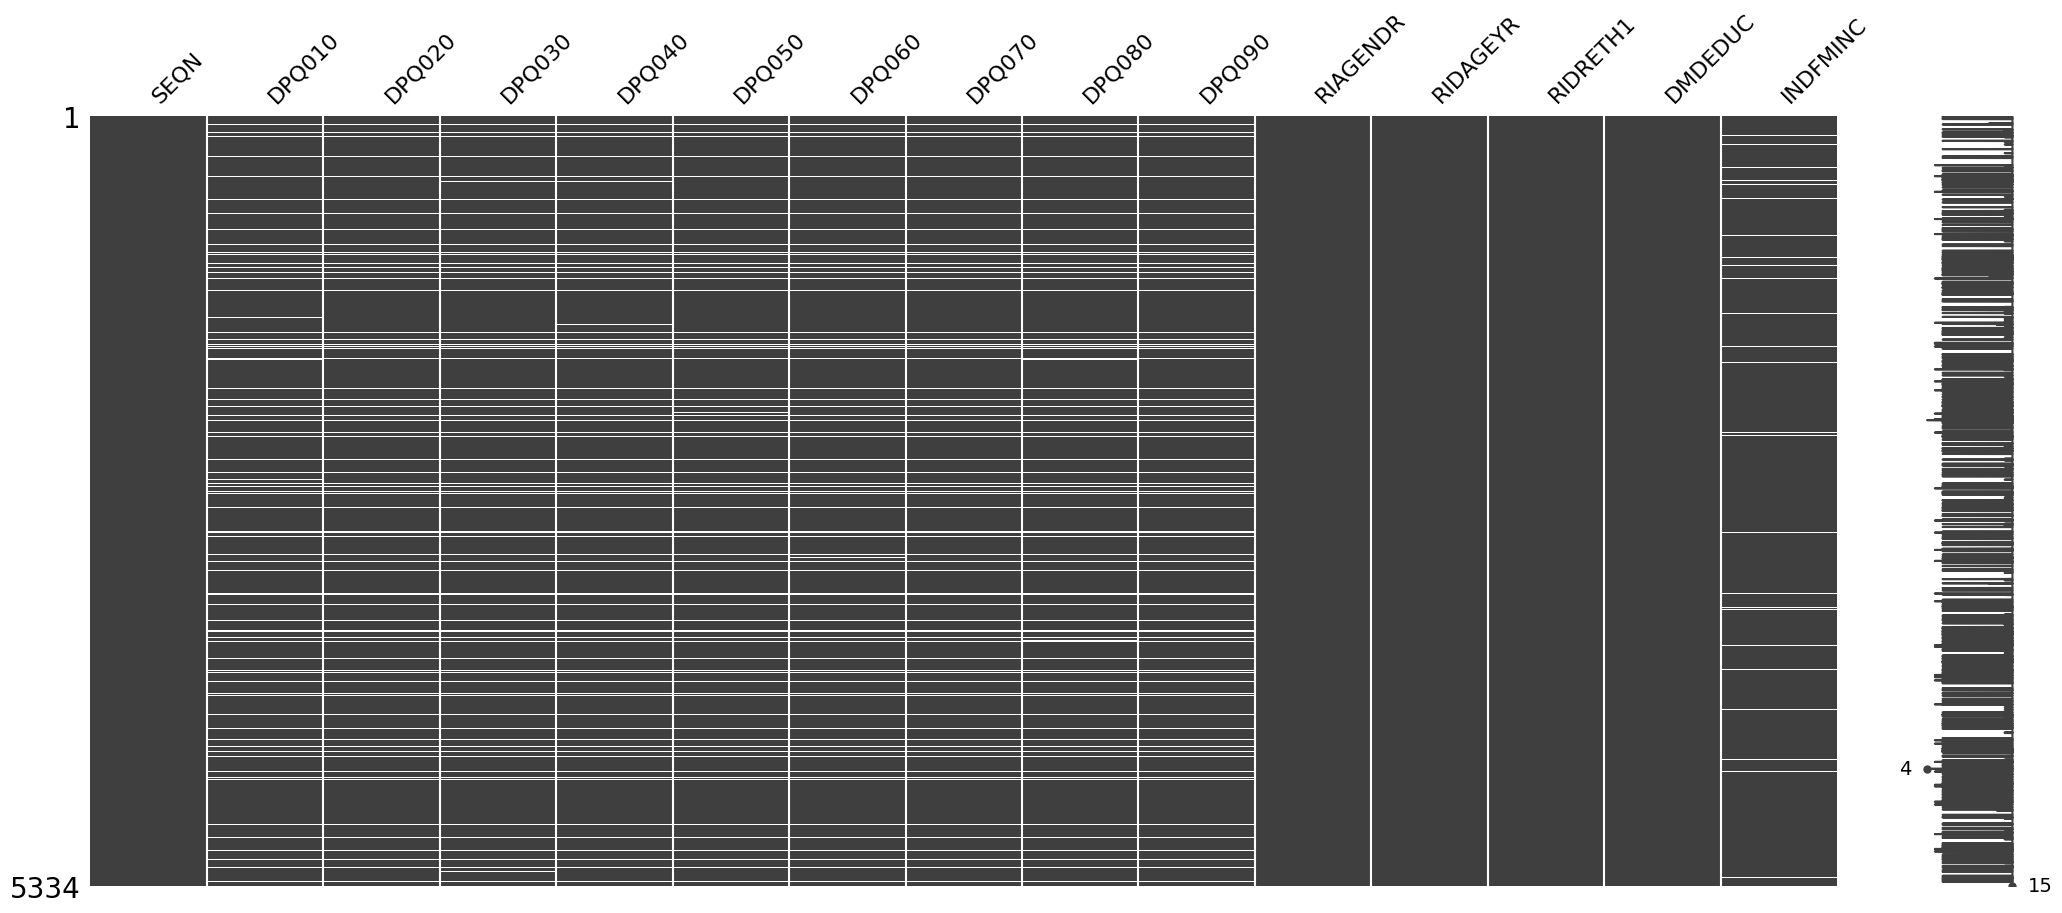

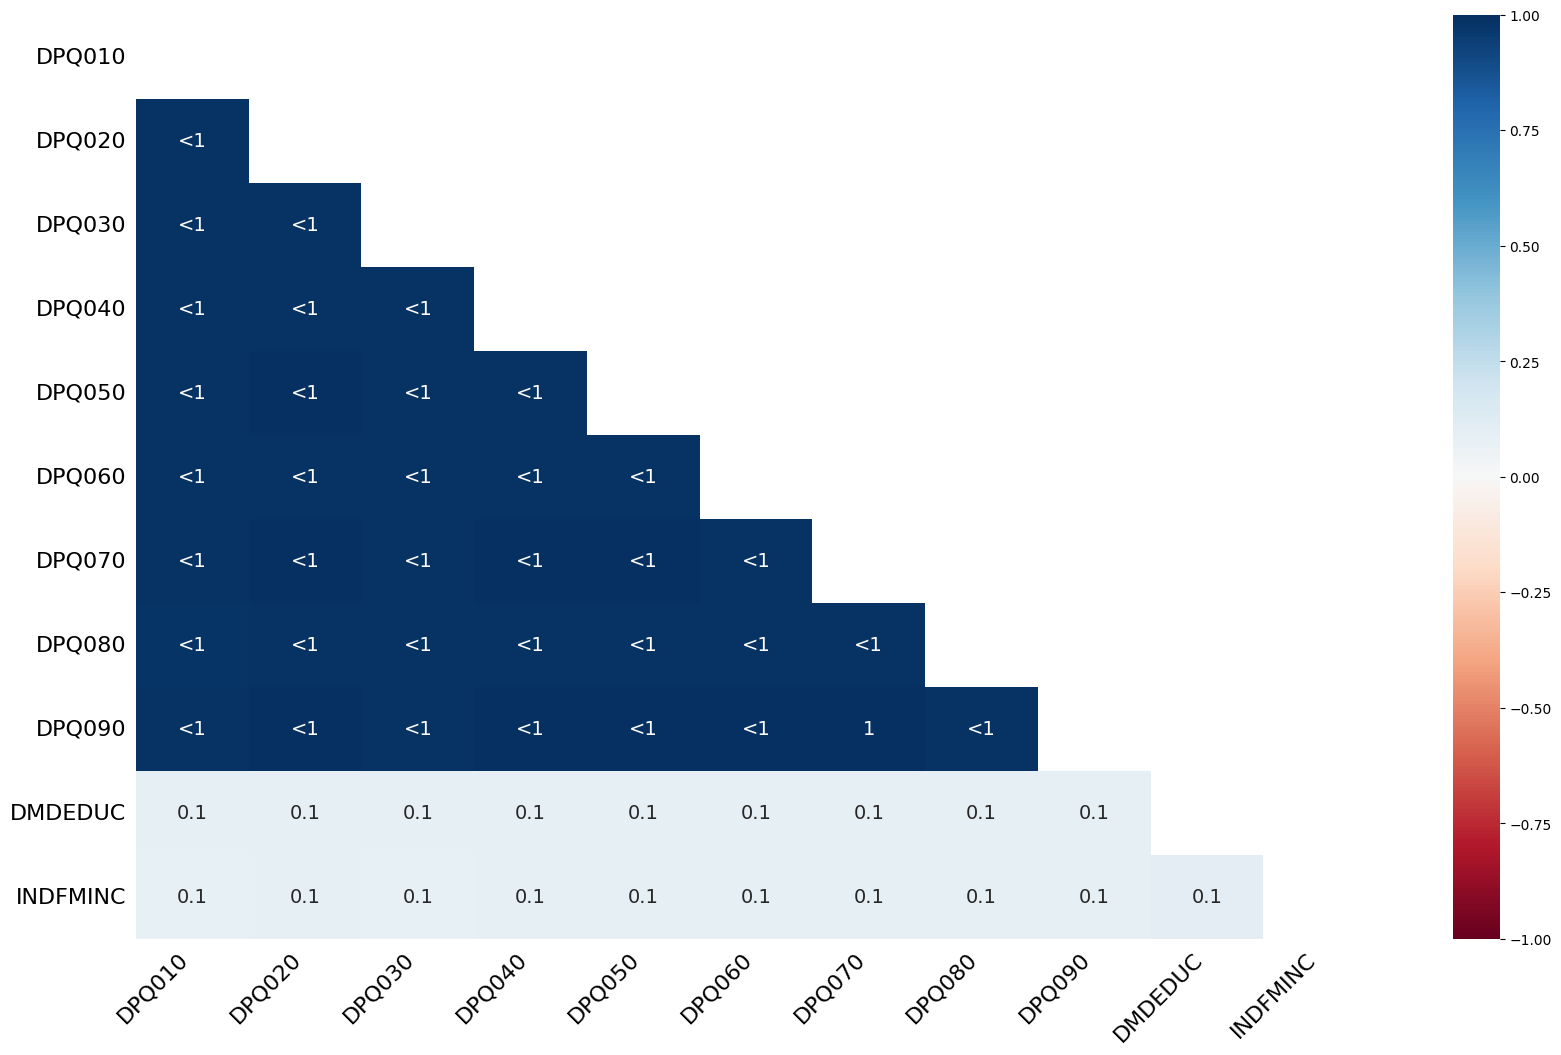

In [9]:
# Visualizando valores nulos
msno.matrix(demo_phq)
msno.heatmap(demo_phq)

### Convertendo colunas categóricas (RIAGENDR, RIDRETH1, DMDEDUC)

Algumas colunas representam informação categórica, mas então preenchidas com números. Vamos converter as respostas para facilitar a visualização.

In [10]:
values_map = {
    'RIAGENDR': {
        1: 'M',
        2: 'F'
    },
    'RIDRETH1': {
        1: 'Bran',
        2: 'Negr',
        3: 'Mexi',
        4: 'Outr',
        5: 'Hisp',
    },
    'DMDEDUC': {
        1: '< 9',
        2: '9 - 12',
        3: 'Ens Med',
        4: 'Sup Incomp',
        5: 'Supr Comp',
    }
}

for col in values_map.keys():
    demo_phq[col] = demo_phq[col].replace(values_map[col])

In [ ]:
demo_phq['DMDEDUC'] = pd.Categorical(
    demo_phq['DMDEDUC'], ['< 9', '9 - 12', 'Ens Med', 'Sup Incomp', 'Supr Comp']
)

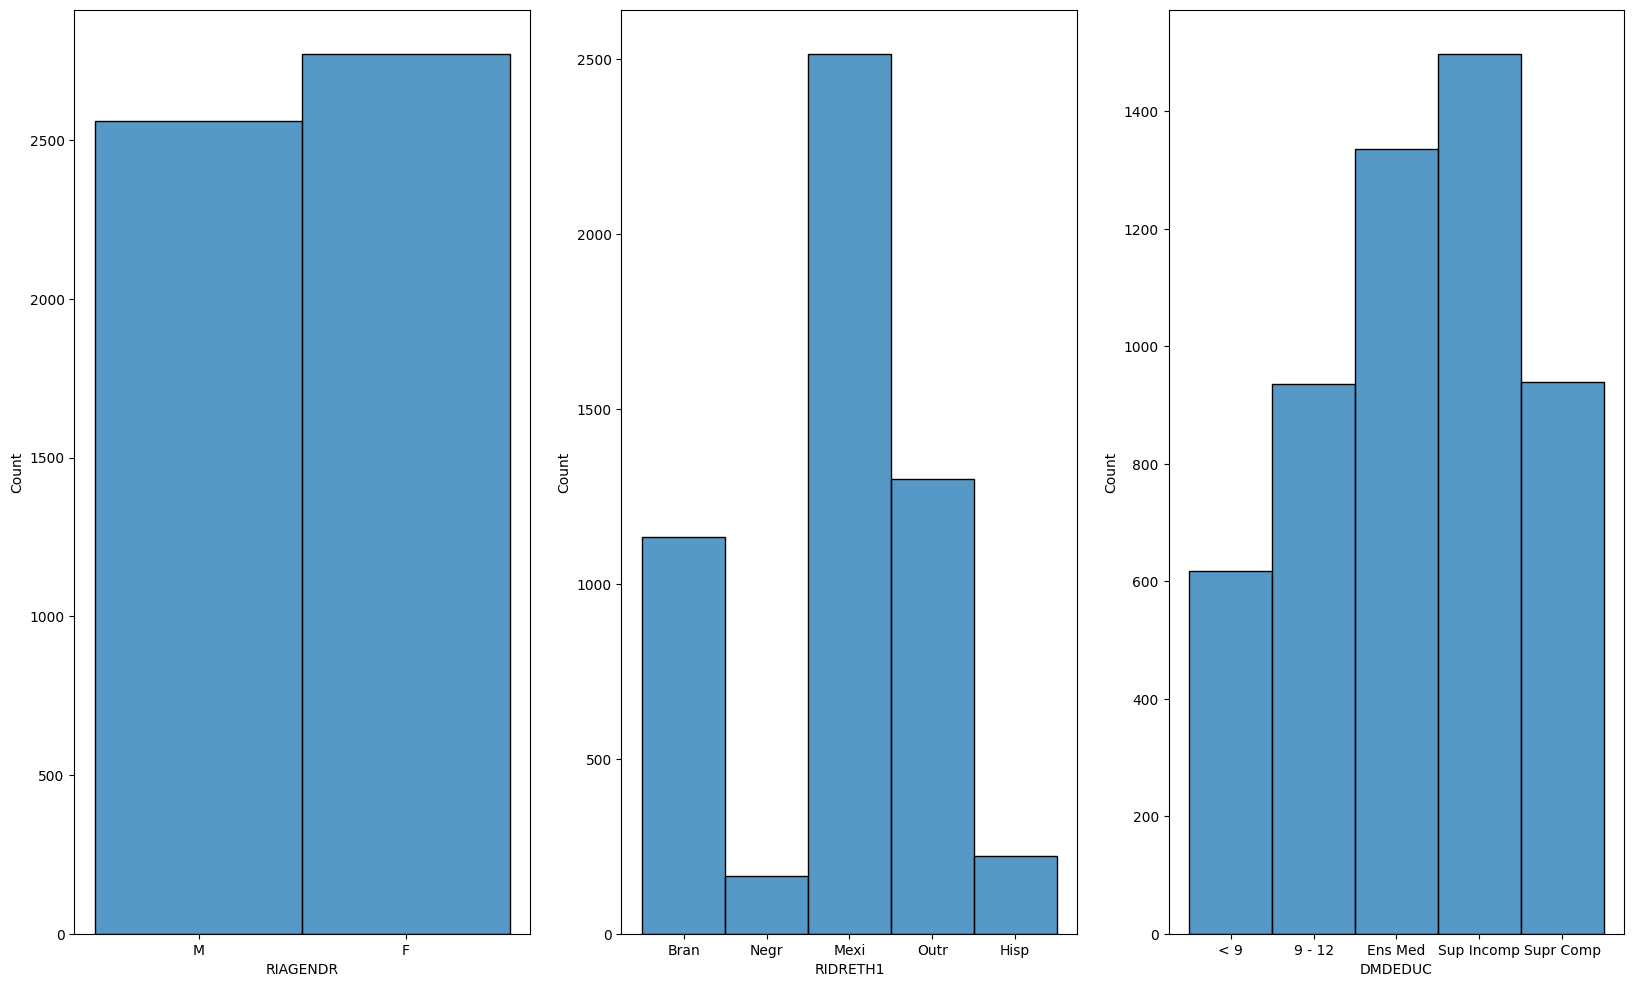

In [12]:
func = sns.histplot
utils.plot_for_cols(demo_phq, values_map.keys(), func=func)

### Calculando scores (PHQ9 e PHQ_GRP)

In [13]:
# Calculando score do PHQ-9
demo_phq['PHQ9'] = demo_phq[phq_cols].sum(axis=1)

A somatória feita acima ignora valores nulos, portanto linhas que não tiveram nenhuma resposta no PHQ-9 ficarão com valor `0.0` na coluna `PHQ9`. Porém isso faz com que elas se misturem com linhas em que todas as respostas do PHQ-9 foram `0`, confundindo as análises.

Portanto, linhas que não tiveram nenhuma resposta no PHQ-9 ficarão com valor nulo (`np.nan`).

In [14]:
# Buscando linhas com todas colunas DPQ vazias
empty_dpq_rows = demo_phq.loc[:,"DPQ010":"DPQ090"].isna().all(1)
empty_dpq_rows = empty_dpq_rows[empty_dpq_rows == True].index

# Preenchando NaN nas colunas novas em linhas que não tiverem nenhuma resposta PHQ
demo_phq.loc[empty_dpq_rows, "PHQ9"] = np.nan

<AxesSubplot: xlabel='PHQ9', ylabel='Count'>

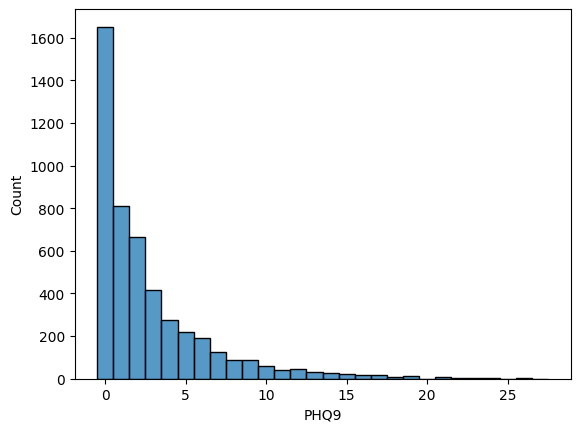

In [15]:
sns.histplot(demo_phq.PHQ9, discrete=True)

<AxesSubplot: >

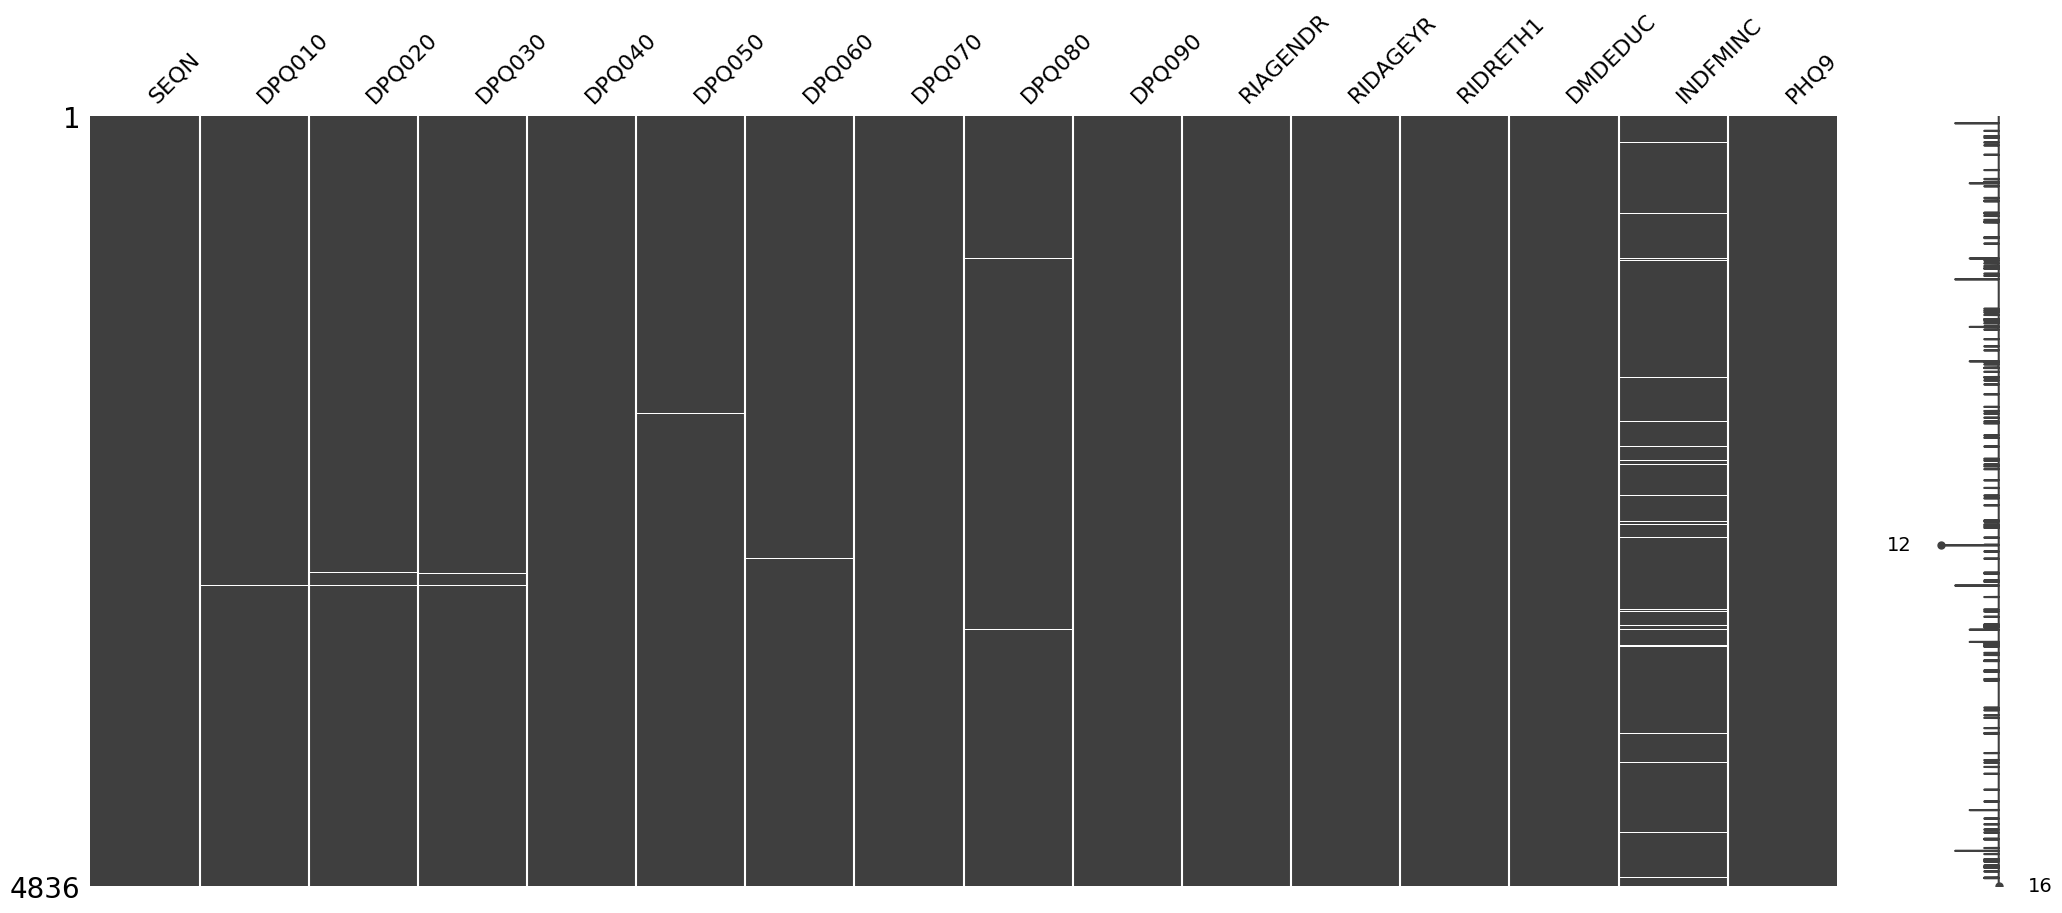

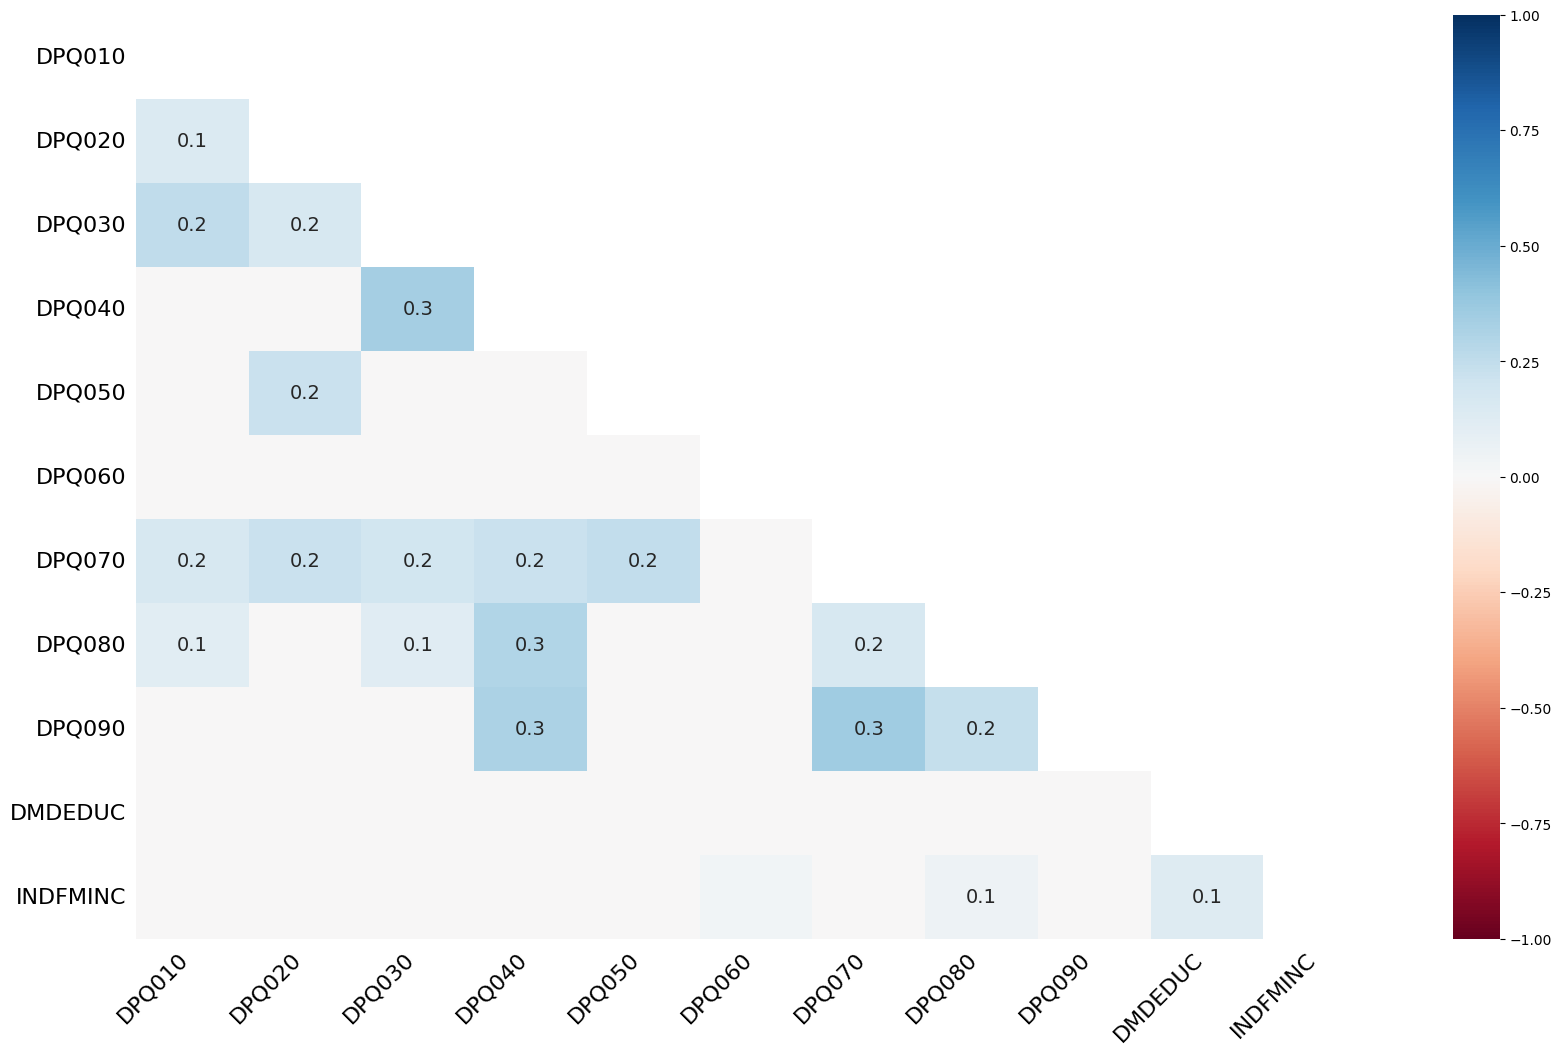

In [16]:
# Visualizando valores nulos, somente entre os que responderam o PHQ-9
msno.matrix(demo_phq[demo_phq.PHQ9.notna()])
msno.heatmap(demo_phq[demo_phq.PHQ9.notna()])

In [17]:
# Calculando grupo de sintomas de depressão
def get_phq9_group(score):
    if score < 5: return 'sem sint'  # sem sintomas
    if score < 10: return 'lev'  # sintomas leves
    if score < 15: return 'mod'  # sintomas moderados
    if score < 19: return 'mod-sev'  # sintomas moderadamente severos
    if score >= 19: return 'sev'  # sintomas severos
    return np.nan  # score nulo

demo_phq['PHQ_GRP'] = demo_phq['PHQ9'].map(get_phq9_group)

In [18]:
# Reordenando colunas para manter as colunas novas junto das respostas PHQ
demo_cols = ['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC', 'INDFMINC']
phq_score_cols = ['PHQ9', 'PHQ_GRP']

ordered_columns = ["SEQN"] + phq_cols + phq_score_cols + demo_cols
demo_phq = demo_phq[ordered_columns]

<AxesSubplot: xlabel='PHQ_GRP', ylabel='Count'>

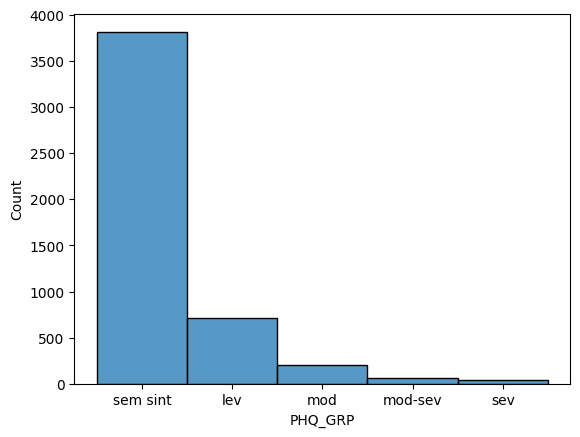

In [19]:
sns.histplot(demo_phq.PHQ_GRP)

## PAG_HEI

### Checando dataset

In [20]:
pag_hei.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SEQN                      9424 non-null   int64  
 1   PAG_MINW                  7150 non-null   float64
 2   ADHERENCE                 7150 non-null   float64
 3   HEI2015C1_TOTALVEG        8549 non-null   float64
 4   HEI2015C2_GREEN_AND_BEAN  8549 non-null   float64
 5   HEI2015C3_TOTALFRUIT      8549 non-null   float64
 6   HEI2015C4_WHOLEFRUIT      8549 non-null   float64
 7   HEI2015C5_WHOLEGRAIN      8549 non-null   float64
 8   HEI2015C6_TOTALDAIRY      8549 non-null   float64
 9   HEI2015C7_TOTPROT         8549 non-null   float64
 10  HEI2015C8_SEAPLANT_PROT   8549 non-null   float64
 11  HEI2015C9_FATTYACID       8549 non-null   float64
 12  HEI2015C10_SODIUM         8549 non-null   float64
 13  HEI2015C11_REFINEDGRAIN   8549 non-null   float64
 14  HEI2015C

In [21]:
pag_hei.describe()

,SEQN,PAG_MINW,ADHERENCE,HEI2015C1_TOTALVEG,HEI2015C2_GREEN_AND_BEAN,HEI2015C3_TOTALFRUIT,HEI2015C4_WHOLEFRUIT,HEI2015C5_WHOLEGRAIN,HEI2015C6_TOTALDAIRY,HEI2015C7_TOTPROT,HEI2015C8_SEAPLANT_PROT,HEI2015C9_FATTYACID,HEI2015C10_SODIUM,HEI2015C11_REFINEDGRAIN,HEI2015C12_SFAT,HEI2015C13_ADDSUG,HEI2015_TOTAL_SCORE
count,"9,424.00","7,150.00","7,150.00","8,549.00","8,549.00","8,549.00","8,549.00","8,549.00","8,549.00","8,549.00","8,549.00","8,549.00","8,549.00","8,549.00","8,549.00","8,549.00","8,549.00"
mean,"36,311.46",565.12,2.07,2.86,1.55,2.66,2.41,1.67,4.05,4.21,2.33,4.21,4.99,5.54,5.78,5.96,48.22
std,"2,991.52",908.84,0.92,1.47,2.05,1.93,2.15,1.82,1.48,1.16,2.13,3.15,3.29,3.45,3.09,3.22,11.88
min,"31,128.00",0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.24
25%,"33,720.75",55.43,1.00,1.69,0.00,0.73,0.00,0.00,3.34,3.59,0.00,1.54,2.26,2.65,3.51,3.60,39.64
50%,"36,307.50",256.35,2.00,2.75,0.00,2.62,2.18,1.02,5.00,5.00,1.84,3.79,5.14,5.88,5.98,6.33,47.59
75%,"38,902.25",696.02,3.00,4.17,3.50,5.00,5.00,3.00,5.00,5.00,5.00,6.46,7.71,8.76,8.39,8.86,56.03
max,"41,474.00","13,801.39",3.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,10.00,10.00,10.00,10.00,10.00,89.53


<AxesSubplot: >

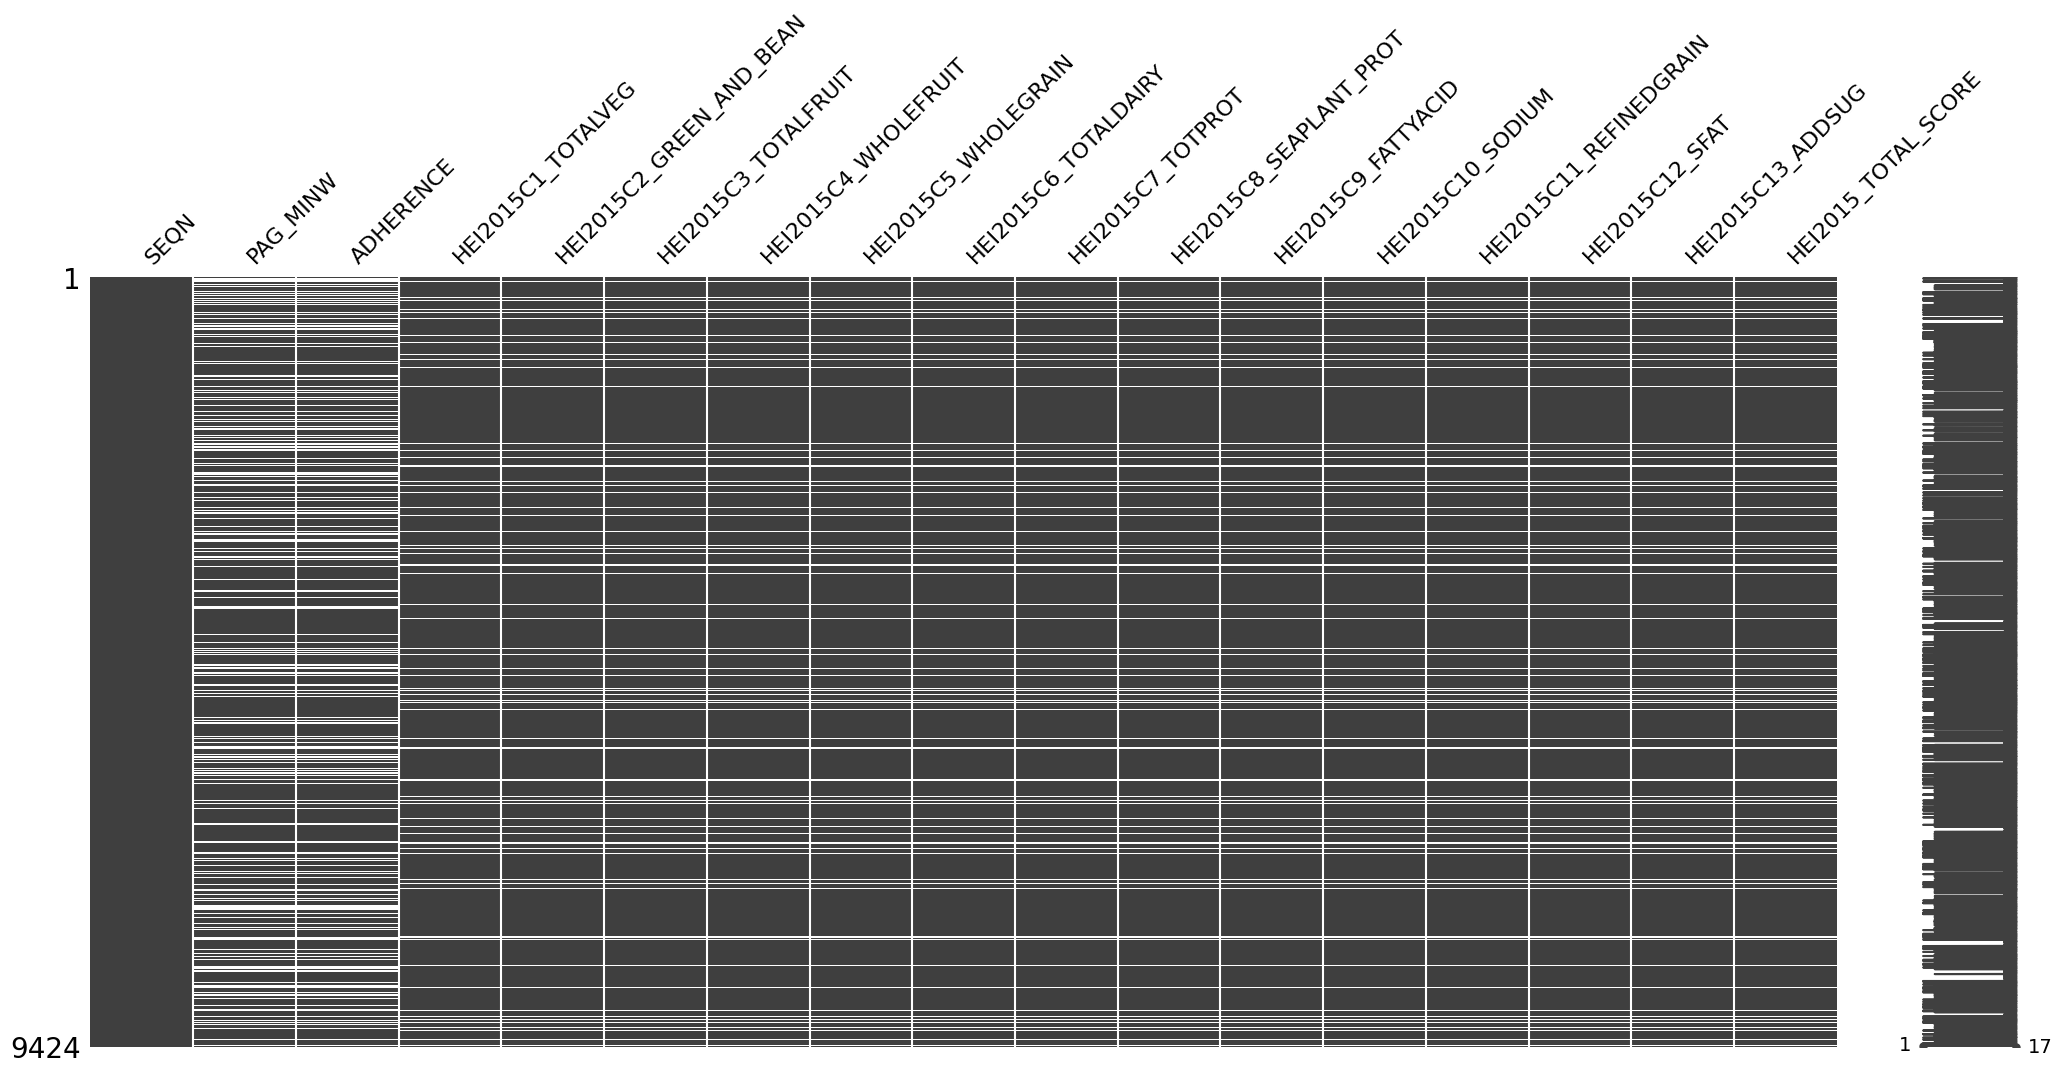

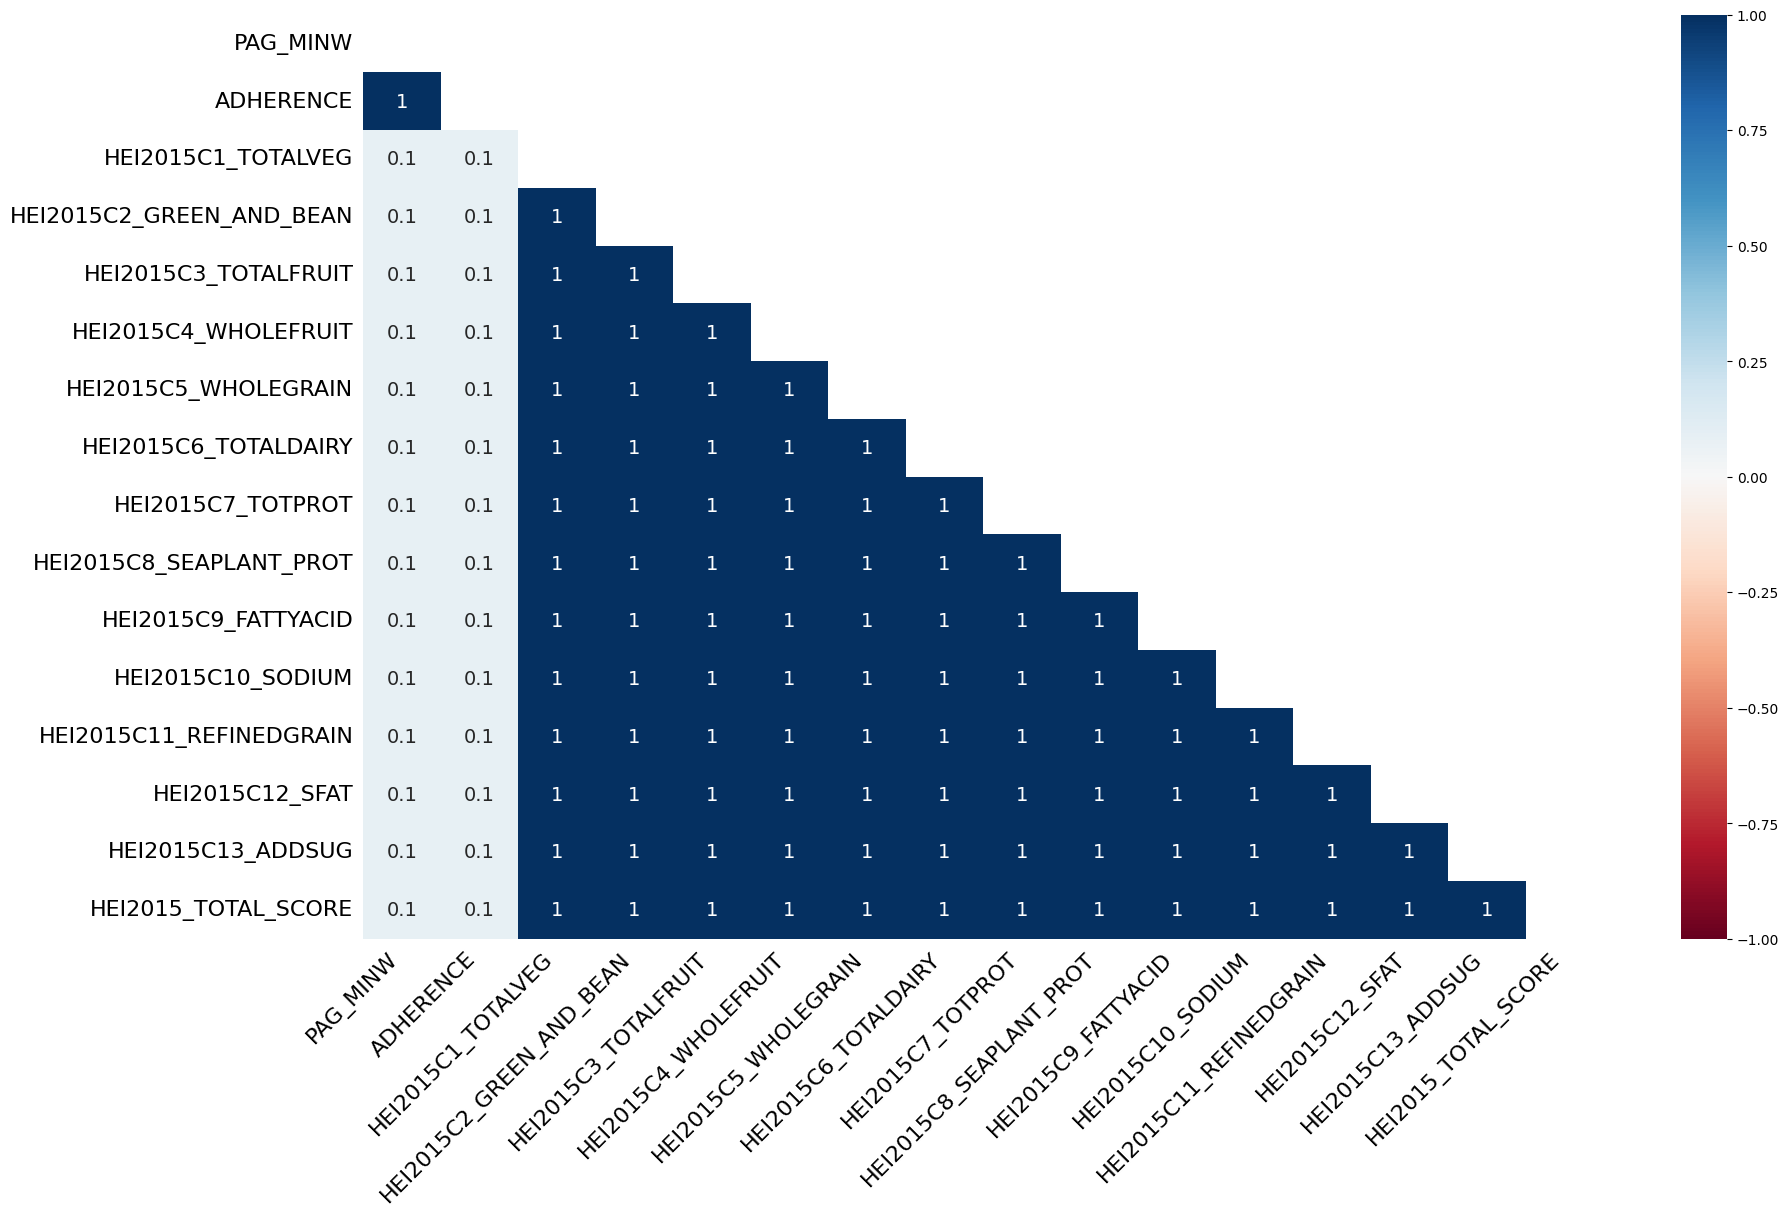

In [22]:
# Visualizando valores nulos
msno.matrix(pag_hei)
msno.heatmap(pag_hei)

In [23]:
# Separando colunas de acordo com a fonte
pag_cols = ['PAG_MINW', 'ADHERENCE']

is_hei_column = lambda x: True if (x.find('HEI2015') > -1) else False
hei_cols = [col for col in pag_hei.columns if is_hei_column(col)]

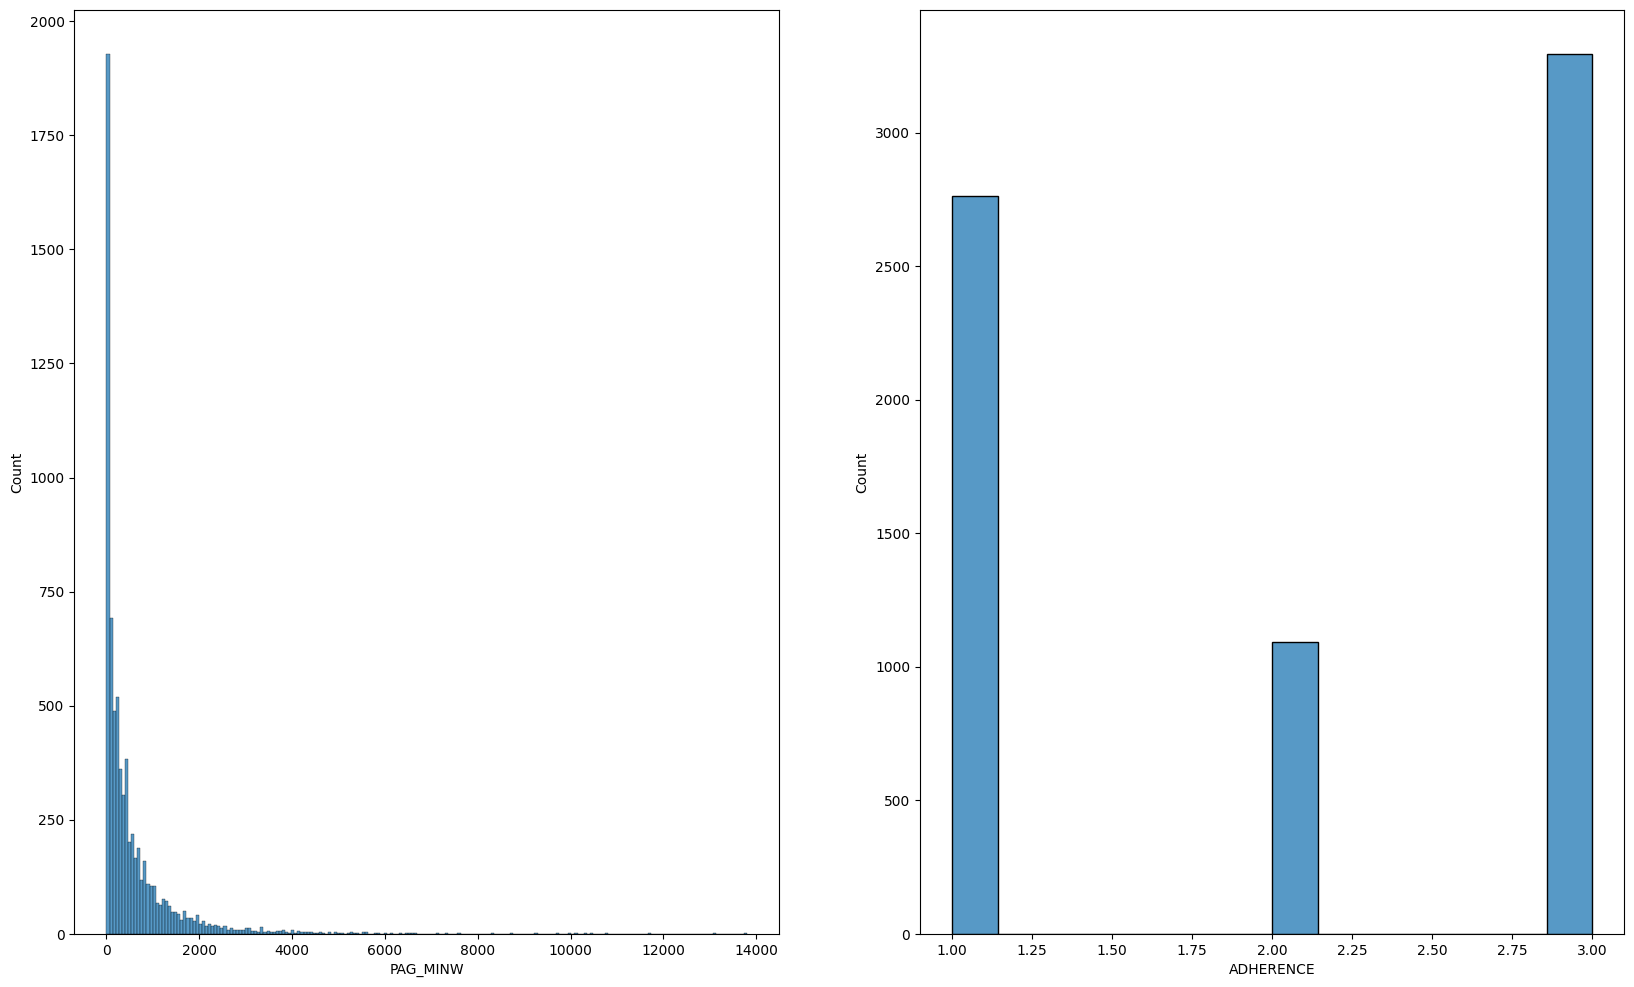

In [24]:
# Visualizando os dados PAG
func = sns.histplot
utils.plot_for_cols(pag_hei, pag_cols, func=func, max_plots_per_row=2)

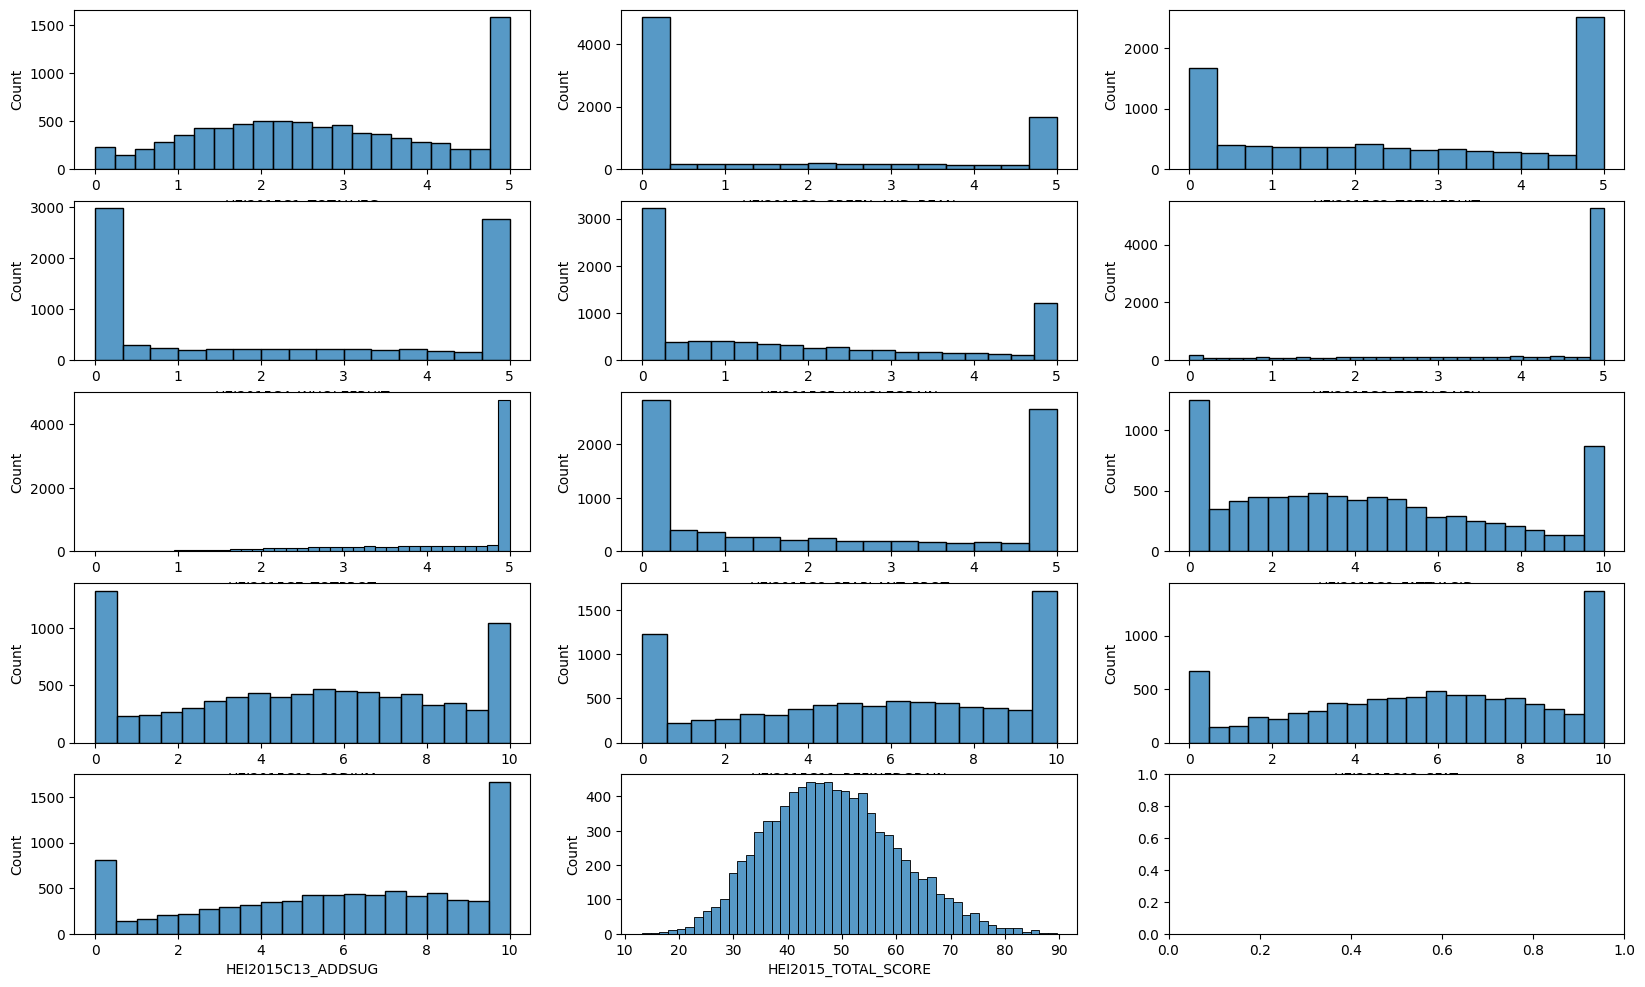

In [25]:
# Visualizando os dados HEI
func = sns.histplot
kwargs = {
    # "discrete": True, 
}

utils.plot_for_cols(pag_hei, hei_cols, func=func, kwargs=kwargs)

### Convertendo coluna categórica (ADHERENCE)

<AxesSubplot: xlabel='ADHERENCE', ylabel='Count'>

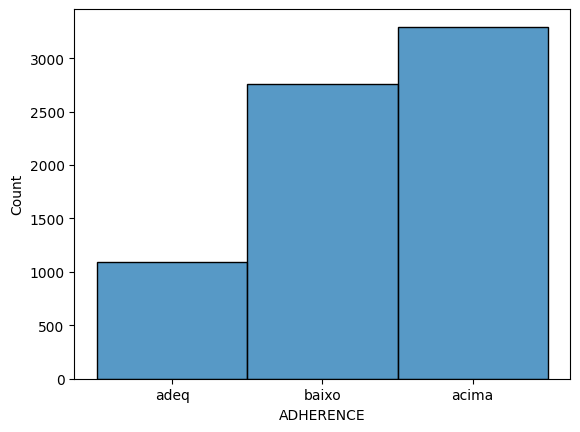

In [26]:
ADHERENCE_values_map = {
    1: 'baixo',
    2: 'adeq',
    3: 'acima',
}
pag_hei['ADHERENCE'].replace(ADHERENCE_values_map, inplace=True)

sns.histplot(pag_hei['ADHERENCE'])

## Mesclagem de datasets

In [27]:
# Mesclando dados de ambos datasets
df = pd.merge(demo_phq, pag_hei, on="SEQN", how="left")

## Validação

Testes adicionados para garantir que a mesclagem foi feita de forma correta

In [36]:
# Checando dimensões após mesclagem
print("demo_phq:", demo_phq.shape)
print("pag_hei:", pag_hei.shape)
print("df mesclado:", df.shape)

assert df.shape[0] == 5334
assert df.shape[1] == demo_phq.shape[1] + pag_hei.shape[1] - 1  # Subtrai 1 pois SEQN aparece em ambos datasets

demo_phq: (5334, 17)
pag_hei: (9424, 17)
df mesclado: (5334, 33)


## Exportação do dataset mesclado
Vamos salvar este dataset mesclado em um novo arquivo, para facilitar as próximas análises

In [37]:
# Exportando o dataframe mesclado
output_path = '../data/output/'
output_file = 'step_1_output.csv'

df.to_csv(f"{output_path}{output_file}", sep=',', encoding='utf-8', index = False)